# Feature Selection & Modelling

In this notebook, I will be using decision tree to identify the feature importance and use them as weights for the columns. Note: Cells are commented out to use the pre-trained pickled file for modelling. You may un-comment them out to re-train the model.

In [1]:
# Base
import pandas as pd
import numpy as np

# Modeling
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.externals import joblib

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
training = pd.read_pickle('datasets/eda_training.pickle')
test = pd.read_pickle('datasets/eda_test.pickle')
data_dict = pd.read_pickle('datadict/data_dict.pickle')

In [4]:
data_dict

,Variable Name,Description,Type,New Column Names
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N,dlq
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage,util_ratio
2,age,Age of borrower in years,integer,age
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer,ph_30to59
4,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage,debtratio
5,MonthlyIncome,Monthly income,real,monthlyincome
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer,open_credit_loans
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer,ph_90
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer,realestate_lines
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days p...,integer,ph_60to89


In [5]:
X = training.drop('dlq',axis=1)
y = training['dlq']

In [6]:
res_X = pd.read_pickle('datasets/SMOTE_res_x.pickle')
res_y = pd.read_pickle('datasets/SMOTE_res_y.pickle')
X_test = pd.read_pickle('datasets/scaled_X_test.pickle')
y_test = pd.read_pickle('datasets/y_test.pickle')
scaled_test = pd.read_pickle('datasets/scaled_test.pickle')

In [7]:
# Setting AUC as scoring metrics

from sklearn.metrics import roc_auc_score, make_scorer

def roc_auc_score_proba(y_true, proba):
    return roc_auc_score(y_true, proba[:, 1])

auc = make_scorer(roc_auc_score_proba, needs_proba=True)# Decision Tree

# Decision Tree

I will be using decision tree for feature selection using feature importance.

In [8]:
# dtc_params = {
#     'max_depth':[1,2,3,4,5,6,7,8],
#     'max_features':[None,'log2','sqrt',2,3,4],
#     'min_samples_split':[2,3,4,5,10,15,20,25]
# }


# dtc_gs = GridSearchCV(DecisionTreeClassifier(random_state=2), dtc_params, cv=3, verbose=1,scoring=auc)
# dtc_gs.fit(res_X, res_y)

In [9]:
# feature_importance = dtc_gs.best_estimator_.feature_importances_

In [10]:
# feature_importance.dump('feature_importance.pickle')

In [11]:
feature_importance = pd.read_pickle('feature_importance.pickle')

In [12]:
pd.DataFrame(feature_importance,index=X.columns).sort_values(by=0,ascending=False)

,0
util_ratio,0.560359
ph_30to59,0.197957
ph_90,0.101242
ph_60to89,0.038669
realestate_lines,0.033640
open_credit_loans,0.030716
age,0.017777
debtratio,0.012359
monthlyincome,0.005810
dependents,0.001472


In [13]:
weighted_X = np.multiply(res_X,feature_importance)
weighted_X_test = np.multiply(X_test,feature_importance)
weighted_test = np.multiply(scaled_test,feature_importance)

# Logistic Regression

In [14]:
# logregcv = LogisticRegressionCV(n_jobs=-1, random_state=2, max_iter=200, cv=3,\
#                                 scoring=auc)
# logregcv.fit(weighted_X, res_y)

In [15]:
# joblib.dump(logregcv, 'models/logregcv_model.pkl')

In [16]:
logregcv = joblib.load('models/logregcv_model.pkl') 

In [17]:
print('Logistic Regression')
print ()
print ('Training Score: {}'.format(logregcv.score(weighted_X,res_y)))   # training score
print ()
print ('Test Score: {}'.format(logregcv.score(weighted_X_test,y_test)))   # test score

Logistic Regression

Training Score: 0.8364509087400653

Test Score: 0.9331333333333334


In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,random_state=2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

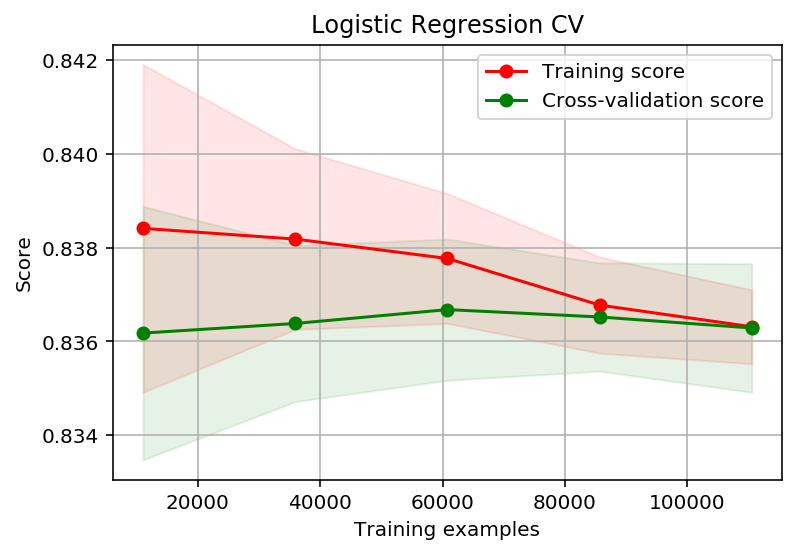

In [21]:
# title = 'Logistic Regression CV'
# estimator = logregcv

# from sklearn.utils import shuffle
# X, y = shuffle(weighted_X, res_y)

# plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#                         n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

Our cross validation score is plateau-ing throughout. This shows that the validation set is unable to learn much from the training data. The training score decrease by only a little bit. It seems that our model is underfitting. We can try to increase the model complexity to see if we can improve on the results. 

# Kaggle Submission

In [97]:
test_predict = logregcv.predict_proba(weighted_test)
test_predict = pd.DataFrame(test_predict)[1]

In [102]:
submission = pd.DataFrame(np.arange(1, len(test_predict) + 1))
submission[1] = test_predict
submission = submission.rename({0:'Id',1:'Probability'},axis=1)


In [106]:
submission.set_index('Id').to_csv('submissions/submission_2.csv')

<img src="https://i.imgur.com/weWdohG.png">

My first Kaggle submission using logistic regression cv provided a score of <b>0.857848 (Private)</b> and <b>0.852654 (Public)</b>

# Random Forest Classifier

In [19]:
# rfc_params = {
#     'n_estimators':[500],
#     'max_depth':[1,2,3,4],
#     'max_features':['log2','sqrt',2,3,4,5],
#     'min_samples_split':[2,3,4,5,10]
# }


# rfc_gs = GridSearchCV(RandomForestClassifier(random_state=6), \
#                       rfc_params, cv=3, verbose=1,n_jobs=-1,scoring='roc_auc')


# rfc_gs.fit(weighted_X, res_y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 100.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=6, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500], 'max_depth': [1, 2, 3, 4], 'max_features': ['log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [23]:
# joblib.dump(rfc_gs, 'models/rfc_model.pkl')

['rfc_model.pkl']

In [30]:
rfc_gs = joblib.load('models/rfc_model.pkl') 

In [24]:
print ('Random Forest Classifier')
print()
print ('Training Score: {}'.format(rfc_gs.score(weighted_X,res_y)))   # training score
print ()
print ('Test Score: {}'.format(rfc_gs.score(weighted_X_test,y_test)))   # test score

Random Forest Classifier

Training Score: 0.927664231492223

Test Score: 0.8379664927311382


# Kaggle Submission

In [25]:
test_predict = rfc_gs.best_estimator_.predict_proba(weighted_test)
test_predict = pd.DataFrame(test_predict)[1]

In [26]:
submission = pd.DataFrame(np.arange(1, len(test_predict) + 1))
submission[1] = test_predict
submission = submission.rename({0:'Id',1:'Probability'},axis=1)

In [27]:
submission.set_index('Id').to_csv('submissions/submission_rfc_gs.csv')

<img src="https://i.imgur.com/fdYGKdb.png">

Kaggle submission using Random Forest Classifier provided a score of <b>0.854492 (Private)</b> and <b>0.848469 (Public)</b>

# XGBoost

[0]	validation_0-auc:0.875727	validation_1-auc:0.796541
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 650 rounds.
[1]	validation_0-auc:0.893441	validation_1-auc:0.820607
[2]	validation_0-auc:0.910799	validation_1-auc:0.816093
[3]	validation_0-auc:0.922211	validation_1-auc:0.815568
[4]	validation_0-auc:0.918506	validation_1-auc:0.818743
[5]	validation_0-auc:0.92289	validation_1-auc:0.836866
[6]	validation_0-auc:0.923988	validation_1-auc:0.834393
[7]	validation_0-auc:0.928934	validation_1-auc:0.835838
[8]	validation_0-auc:0.929911	validation_1-auc:0.835931
[9]	validation_0-auc:0.933556	validation_1-auc:0.835171
[10]	validation_0-auc:0.933596	validation_1-auc:0.8326
[11]	validation_0-auc:0.932495	validation_1-auc:0.83287
[12]	validation_0-auc:0.934484	validation_1-auc:0.834683
[13]	validation_0-auc:0.934023	validation_1-auc:0.834081
[14]	validation_0-auc:0.934304	validation_1-auc:0.832873
[

[141]	validation_0-auc:0.938841	validation_1-auc:0.832064
[142]	validation_0-auc:0.938745	validation_1-auc:0.832041
[143]	validation_0-auc:0.938699	validation_1-auc:0.832679
[144]	validation_0-auc:0.938721	validation_1-auc:0.832706
[145]	validation_0-auc:0.938753	validation_1-auc:0.83297
[146]	validation_0-auc:0.938775	validation_1-auc:0.833169
[147]	validation_0-auc:0.938825	validation_1-auc:0.833081
[148]	validation_0-auc:0.938825	validation_1-auc:0.832366
[149]	validation_0-auc:0.938698	validation_1-auc:0.832949
[150]	validation_0-auc:0.938962	validation_1-auc:0.832187
[151]	validation_0-auc:0.939017	validation_1-auc:0.832445
[152]	validation_0-auc:0.938954	validation_1-auc:0.833093
[153]	validation_0-auc:0.938987	validation_1-auc:0.833114
[154]	validation_0-auc:0.938924	validation_1-auc:0.833849
[155]	validation_0-auc:0.939095	validation_1-auc:0.833849
[156]	validation_0-auc:0.93902	validation_1-auc:0.833747
[157]	validation_0-auc:0.939113	validation_1-auc:0.833812
[158]	validation

[283]	validation_0-auc:0.941076	validation_1-auc:0.832546
[284]	validation_0-auc:0.941222	validation_1-auc:0.832464
[285]	validation_0-auc:0.941293	validation_1-auc:0.832231
[286]	validation_0-auc:0.941298	validation_1-auc:0.831974
[287]	validation_0-auc:0.94137	validation_1-auc:0.831568
[288]	validation_0-auc:0.941357	validation_1-auc:0.83153
[289]	validation_0-auc:0.941401	validation_1-auc:0.831542
[290]	validation_0-auc:0.941487	validation_1-auc:0.831415
[291]	validation_0-auc:0.941484	validation_1-auc:0.831419
[292]	validation_0-auc:0.94152	validation_1-auc:0.831321
[293]	validation_0-auc:0.941505	validation_1-auc:0.831498
[294]	validation_0-auc:0.94147	validation_1-auc:0.831784
[295]	validation_0-auc:0.941443	validation_1-auc:0.832082
[296]	validation_0-auc:0.941477	validation_1-auc:0.832381
[297]	validation_0-auc:0.941546	validation_1-auc:0.832057
[298]	validation_0-auc:0.9416	validation_1-auc:0.831968
[299]	validation_0-auc:0.941569	validation_1-auc:0.832299
[300]	validation_0-a

[425]	validation_0-auc:0.944663	validation_1-auc:0.832659
[426]	validation_0-auc:0.944692	validation_1-auc:0.832779
[427]	validation_0-auc:0.944724	validation_1-auc:0.832655
[428]	validation_0-auc:0.944743	validation_1-auc:0.832575
[429]	validation_0-auc:0.944772	validation_1-auc:0.832581
[430]	validation_0-auc:0.944804	validation_1-auc:0.832583
[431]	validation_0-auc:0.94481	validation_1-auc:0.832514
[432]	validation_0-auc:0.944819	validation_1-auc:0.832295
[433]	validation_0-auc:0.944829	validation_1-auc:0.83232
[434]	validation_0-auc:0.944828	validation_1-auc:0.832313
[435]	validation_0-auc:0.944898	validation_1-auc:0.832035
[436]	validation_0-auc:0.944929	validation_1-auc:0.832035
[437]	validation_0-auc:0.944972	validation_1-auc:0.832122
[438]	validation_0-auc:0.945008	validation_1-auc:0.832233
[439]	validation_0-auc:0.94499	validation_1-auc:0.832324
[440]	validation_0-auc:0.94499	validation_1-auc:0.832492
[441]	validation_0-auc:0.944997	validation_1-auc:0.832525
[442]	validation_0

[567]	validation_0-auc:0.947801	validation_1-auc:0.833792
[568]	validation_0-auc:0.947833	validation_1-auc:0.833782
[569]	validation_0-auc:0.947846	validation_1-auc:0.833852
[570]	validation_0-auc:0.947951	validation_1-auc:0.83379
[571]	validation_0-auc:0.947964	validation_1-auc:0.833838
[572]	validation_0-auc:0.947971	validation_1-auc:0.833821
[573]	validation_0-auc:0.948035	validation_1-auc:0.833759
[574]	validation_0-auc:0.948073	validation_1-auc:0.833749
[575]	validation_0-auc:0.948084	validation_1-auc:0.83374
[576]	validation_0-auc:0.948064	validation_1-auc:0.833822
[577]	validation_0-auc:0.948106	validation_1-auc:0.833784
[578]	validation_0-auc:0.948113	validation_1-auc:0.833707
[579]	validation_0-auc:0.948097	validation_1-auc:0.833805
[580]	validation_0-auc:0.948224	validation_1-auc:0.833529
[581]	validation_0-auc:0.948242	validation_1-auc:0.833503
[582]	validation_0-auc:0.948251	validation_1-auc:0.833595
[583]	validation_0-auc:0.948277	validation_1-auc:0.83365
[584]	validation_

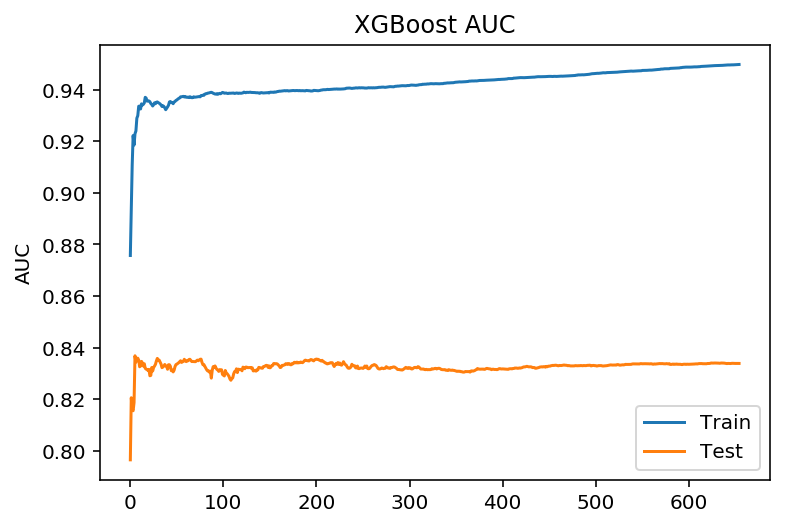

In [23]:
# # plot learning curve
# from matplotlib import pyplot

# # fit model
# model = XGBClassifier(max_depth=4, learning_rate=0.005, n_estimators=1000, silent=True, \
#                       objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, \
#                       gamma=0.65, min_child_weight=10, subsample=0.8, colsample_bytree=0.4, \
#                       random_state=2, seed=None, missing=None)

# eval_set = [(weighted_X,res_y), (np.array(weighted_X_test),np.array(y_test))]
# model.fit(weighted_X,res_y, eval_metric=["auc"], eval_set=eval_set, verbose=True,early_stopping_rounds=650)

# # retrieve performance metrics
# results = model.evals_result()
# epochs = len(results['validation_0']['auc'])
# x_axis = range(0, epochs)

# # plot auc
# fig, ax = pyplot.subplots()
# ax.plot(x_axis, results['validation_0']['auc'], label='Train')
# ax.plot(x_axis, results['validation_1']['auc'], label='Test')
# ax.legend()
# pyplot.ylabel('AUC')
# pyplot.title('XGBoost AUC')
# pyplot.show()



In [24]:
# joblib.dump(model, 'models/xgboost_2.pkl')

['xgboost_2.pkl']

In [25]:
xgb = joblib.load('models/xgboost_2.pkl')

In [27]:
print ('XGBoost')
print()
print ('Training Score: {}'.format(xgb.score(weighted_X,res_y)))   # training score
print ()
print ('Test Score: {}'.format(xgb.score(np.array(weighted_X_test),y_test)))   # test score

XGBoost

Training Score: 0.872324131360276

Test Score: 0.8680444444444444


In [28]:
test_predict = xgb.predict_proba(weighted_test)
test_predict = pd.DataFrame(test_predict)[1]

submission = pd.DataFrame(np.arange(1, len(test_predict) + 1))
submission[1] = test_predict
submission = submission.rename({0:'Id',1:'Probability'},axis=1)

submission.set_index('Id').to_csv('submissions/submission_xgb_2.csv')

<img src="https://i.imgur.com/UV98JuJ.png">

Kaggle submission using XGBoost provided a score of <b>0.859874 (Private)</b> and <b>0.853010 (Public)</b>